# Classifiez automatiquement des biens de consommation : *Notebook mission 1"

**Etudiez la faisabilité d'un moteur de classification d'articles**

Vous êtes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce. Sur cette place de marché anglophone, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.
 

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle,  il devient nécessaire d'automatiser cette tâche d‘attribution de la catégo

Objectif : Etudier la faisabilité d'un moteur de classification des articles en différentes catégories, à partir du texte (en anglais) et de l’image comme dans l’illustration ci-dessous.rie.

In [34]:
import numpy as np

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import scipy
from scipy import stats
import scipy.stats as st

import statsmodels
import statsmodels.api as sm
import missingno as msno

import sklearn

from sklearn.impute import KNNImputer
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from category_encoders import TargetEncoder

# pour le centrage et la réduction
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# pour l'ACP
from sklearn.decomposition import PCA

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix

from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

import nltk

import timeit

# pour cartographie
import folium
import cartopy.crs as ccrs
import geopandas as gpd
import contextily as ctx

from collections import defaultdict

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("scipy version", scipy.__version__)
print("statsmodels version", statsmodels.__version__)
print("missingno version", msno.__version__)

print("sklearn version", sklearn.__version__)

print("nltk version", nltk.__version__)

print("folium version", folium.__version__)

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
seaborn version 0.13.2
scipy version 1.11.4
statsmodels version 0.14.0
missingno version 0.5.2
sklearn version 1.2.2
nltk version 3.8.1
folium version 0.19.2


## 1 - Etudier la faisabilité de classification en utilisant des méthodes NLP basiques

### 1.1 - Prétraitement des données textes

Il s'agit de réaliser le pré traitement sur la description des articles.

#### Charger les données textes

In [8]:
# Charger le fichier de données
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_6/data_projet/Dataset+projet+prétraitement+textes+images/Flipkart/flipkart_com-ecommerce_sample_1050.csv", \
                   sep=',', low_memory=False)
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [10]:
data.shape

(1050, 15)

Regardons les valeurs manquantes :

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

Tous les articles ont une description et un product_category_tree.

Regardons les doublons :

In [19]:
data.nunique()

uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

Il n'y a pas de doublon.

#### Exploration des descriptions : tokenisation et analyse des fréquences

In [58]:
# tokenizer pour conserver uniquement les caractères alphanumériques
tokenizer = nltk.RegexpTokenizer(r'\w+')
tokenizer.tokenize(data.iloc[0]['description'])

['Key',
 'Features',
 'of',
 'Elegance',
 'Polyester',
 'Multicolor',
 'Abstract',
 'Eyelet',
 'Door',
 'Curtain',
 'Floral',
 'Curtain',
 'Elegance',
 'Polyester',
 'Multicolor',
 'Abstract',
 'Eyelet',
 'Door',
 'Curtain',
 '213',
 'cm',
 'in',
 'Height',
 'Pack',
 'of',
 '2',
 'Price',
 'Rs',
 '899',
 'This',
 'curtain',
 'enhances',
 'the',
 'look',
 'of',
 'the',
 'interiors',
 'This',
 'curtain',
 'is',
 'made',
 'from',
 '100',
 'high',
 'quality',
 'polyester',
 'fabric',
 'It',
 'features',
 'an',
 'eyelet',
 'style',
 'stitch',
 'with',
 'Metal',
 'Ring',
 'It',
 'makes',
 'the',
 'room',
 'environment',
 'romantic',
 'and',
 'loving',
 'This',
 'curtain',
 'is',
 'ant',
 'wrinkle',
 'and',
 'anti',
 'shrinkage',
 'and',
 'have',
 'elegant',
 'apparance',
 'Give',
 'your',
 'home',
 'a',
 'bright',
 'and',
 'modernistic',
 'appeal',
 'with',
 'these',
 'designs',
 'The',
 'surreal',
 'attention',
 'is',
 'sure',
 'to',
 'steal',
 'hearts',
 'These',
 'contemporary',
 'eyelet'

In [39]:
def freq_stats_from_dataframe(df):
    """
    Calcule les fréquences des mots à partir d'un DataFrame contenant les noms d'image et descriptions.
    
    Args:
    - df (pd.DataFrame): DataFrame avec deux colonnes ['image_name', 'description'].
    
    Returns:
    - freq (dict): Fréquences des mots pour chaque image.
    - stats (pd.DataFrame): DataFrame des statistiques par image.
    """
    corpora = defaultdict(list)
    
    # Construction du corpus par image
    for _, row in df.iterrows():
        image_name = row['image']
        description = row['description']
        
        # Tokenisation de la description
        tokens = tokenizer.tokenize(description.lower())
        corpora[image_name] += tokens
    
    # Calcul des fréquences et des statistiques
    freq = {image: nltk.FreqDist(words) for image, words in corpora.items()}
    stats = {image: {'total': len(words)} for image, words in corpora.items()}
    
    # Conversion des statistiques en DataFrame
    stats_df = pd.DataFrame.from_dict(stats, orient='index')
    
    return freq, stats_df

In [41]:
# Application de la fonction
freq, stats_df = freq_stats_from_dataframe(data)

# Affichage des résultats (total = nombre de mots)
print(stats_df)

                                      total
009099b1f6e1e8f893ec29a7023153c4.jpg     38
0096e89cc25a8b96fb9808716406fe94.jpg     61
00cbbc837d340fa163d11e169fbdb952.jpg     24
00d84a518e0550612fcfcba3b02b6255.jpg     39
00e966a5049a262cfc72e6bbf68b80e7.jpg    235
...                                     ...
feefbdff924dd6b7cc266449c9a36d69.jpg    123
ff24511994fc459d04145231c8876d6c.jpg     22
ffbf3794aa8cb6bb8d3f313d0a549a09.jpg     37
ffc2e1fc7c886ec09a331040ada038aa.jpg     20
fffa2117a4006d4a848eb7d5b80d4816.jpg     41

[1050 rows x 1 columns]


Regardons le résultat pour un article particulier :

In [60]:
# Exemple d'accès aux fréquences des mots pour une image spécifique
print(freq["55b85ea15a1536d46b7190ad6fff8ce7.jpg"].most_common())

[('the', 13), ('of', 10), ('curtain', 9), ('in', 7), ('polyester', 6), ('eyelet', 6), ('and', 6), ('door', 5), ('2', 5), ('you', 5), ('elegance', 4), ('multicolor', 4), ('abstract', 4), ('to', 4), ('213', 3), ('cm', 3), ('pack', 3), ('this', 3), ('is', 3), ('features', 2), ('height', 2), ('it', 2), ('with', 2), ('room', 2), ('elegant', 2), ('your', 2), ('home', 2), ('bright', 2), ('these', 2), ('curtains', 2), ('so', 2), ('when', 2), ('draw', 2), ('them', 2), ('morning', 2), ('that', 2), ('model', 2), ('sales', 2), ('package', 2), ('key', 1), ('floral', 1), ('price', 1), ('rs', 1), ('899', 1), ('enhances', 1), ('look', 1), ('interiors', 1), ('made', 1), ('from', 1), ('100', 1), ('high', 1), ('quality', 1), ('fabric', 1), ('an', 1), ('style', 1), ('stitch', 1), ('metal', 1), ('ring', 1), ('makes', 1), ('environment', 1), ('romantic', 1), ('loving', 1), ('ant', 1), ('wrinkle', 1), ('anti', 1), ('shrinkage', 1), ('have', 1), ('apparance', 1), ('give', 1), ('a', 1), ('modernistic', 1), ('a

<Axes: title={'center': 'Top 20 images par nombre total de mots'}>

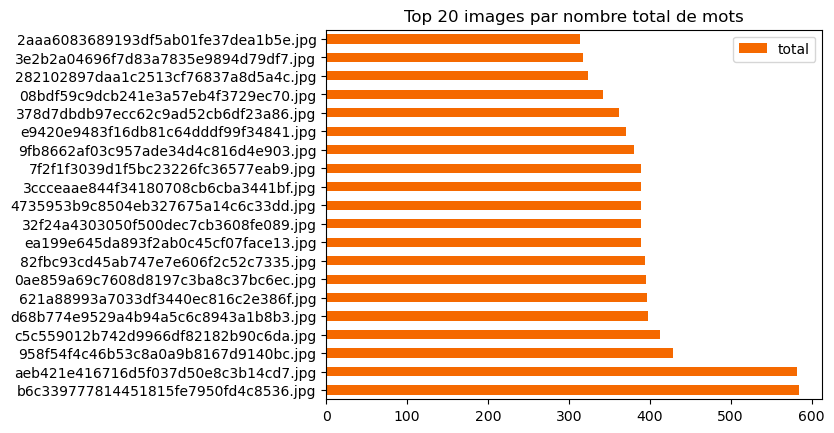

In [54]:
stats_df.sort_values(by='total', ascending=False).head(20).plot(
    kind='barh',
    color="#f56900",
    title='Top 20 images par nombre total de mots'
)